In [97]:
import torch
import pandas as pd
from torch.autograd import grad
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import astropy.units as u
import gala.potential as gp
from gala.units import galactic

from stream_evolution_potential import NFW, Plummer, run

In [3]:
### First define the Halo and Progenitor ###

halo_mass     = 7.5e11 * u.M_sun
concentration = 20.
flattening_xy  = 1.
flattening_xz  = 1.

halo = NFW(halo_mass, concentration, flattening_xy, flattening_xz)

progenitor_mass = 6.48e8 * u.M_sun # M_sun
alpha = 0.85 * u.kpc # kpc
progenitor = Plummer(progenitor_mass,alpha) 

In [4]:
### Run Stream simulation ###

t_start, t_end, dt = 0, 4, 1e-3 # Gyr
pos_prog = [60, -60, 10] # kpc

pos_scat = [0, 0, 0] # kpc


vel_prog = [0, 100, 0] # km/s
vel_scat = [0, 5, 0] #km/s
N = 2 # amount of star ejected per dt

factor = 1.0 # factor to multiply the tidal radius

time, all_pos_prog, all_vel_prog, all_pos_N, all_vel_N, all_xhi_N, all_rt, all_L1, all_L2 = run(t_start, t_end, dt, halo, progenitor, pos_prog, vel_prog, vel_scat, N, factor)

100%|██████████| 4001/4001 [00:20<00:00, 197.62it/s]


In [156]:
np.savetxt('x_orbit.txt', x1)
np.savetxt('y_orbit.txt', y1)

In [29]:
n_orbit = 10
arg_trail = np.arange(1, 8002, 800)[:-1].astype(int)

In [31]:
x_trail = all_pos_N[0, :, arg_trail]
y_trail = all_pos_N[1, :, arg_trail]

In [95]:
# Ensure that the unwrapped angles are monotonically increasing
def check_angle(unwrapped_angles):
    arg_decrease = np.where( np.diff(unwrapped_angles) <= 0 )[0]
    for i in arg_decrease:
        unwrapped_angles[i+1:] += 2 * np.pi

    return unwrapped_angles

first_theta = []
for index, i in enumerate(arg_trail):
    x = x_trail[index, i//2:]
    y = y_trail[index, i//2:]
    first_theta.append(np.arctan2(y[0], x[0]))
adjust_theta = check_angle(np.unwrap( first_theta - first_theta[0]))

In [113]:
first_theta

[-0.7845605402534581,
 -0.027047702976004187,
 3.0203327193425027,
 -2.869091988319875,
 -2.589672711223587,
 -2.0471073453703887,
 1.1386673419099813,
 1.5984217763570785,
 1.8697644929549655,
 2.3010556971848035]

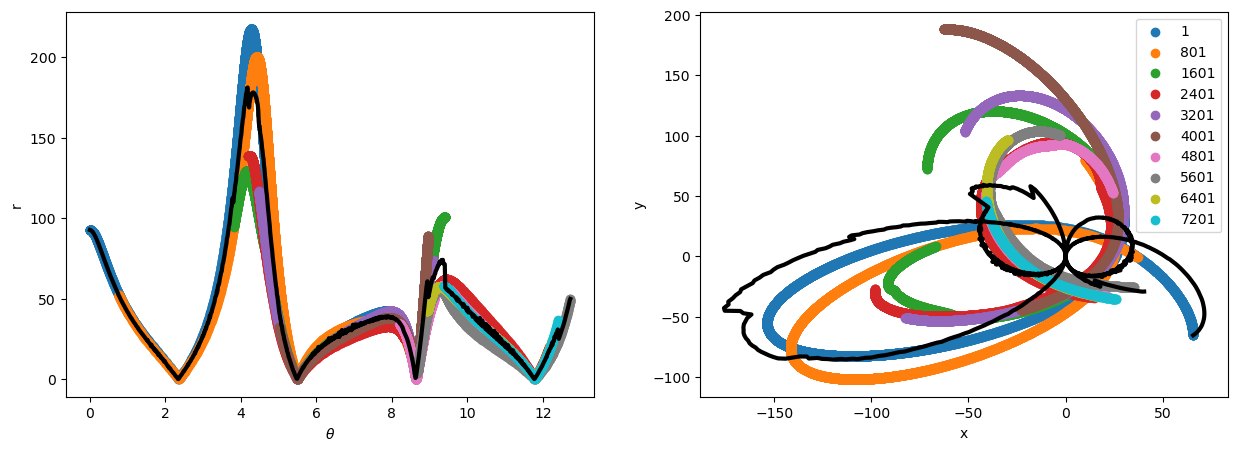

In [136]:
plt.figure(figsize=(15,5))
r_all = []
theta_all = []
for index, i in enumerate(arg_trail):
    x = x_trail[index, i//2:]
    y = y_trail[index, i//2:]
    r = np.sqrt(x**2 + x**2)
    theta = np.arctan2(y, x)
    theta_shifted = theta - theta[0]
    theta_unwrapped = check_angle(np.unwrap(theta_shifted + adjust_theta[index]))

    r_all.extend(r)
    theta_all.extend(theta_unwrapped)

    plt.subplot(1,2,1)
    plt.scatter(theta_unwrapped, r)
    plt.xlabel(r'$\theta$')
    plt.ylabel('r')
    plt.subplot(1,2,2)
    plt.scatter(x,y, label=f'{i}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

def average_column(x,y):
    bins = np.linspace(np.min(x), np.max(x), 1001)

    # Bin the x array
    binned_x = np.digitize(x, bins)

    # Create a DataFrame for easy calculation
    df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

    # Group by the bin and calculate mean
    average_y_per_bin = df.groupby('bin')['y'].mean()

    return average_y_per_bin.to_numpy()

r_mean = average_column(theta_all, r_all)
theta_mean = np.linspace(np.min(theta_all), np.max(theta_all), len(r_mean))
theta_norm = (theta_mean + first_theta[0] + np.pi) % (2 * np.pi) - np.pi #(theta_mean % (2*np.pi) ) - np.pi

plt.subplot(1,2,1)
plt.plot(theta_mean, r_mean, 'k', linewidth=3)
plt.subplot(1,2,2)
plt.plot(r_mean*np.cos(theta_norm), r_mean*np.sin(theta_norm), 'k', linewidth=3)

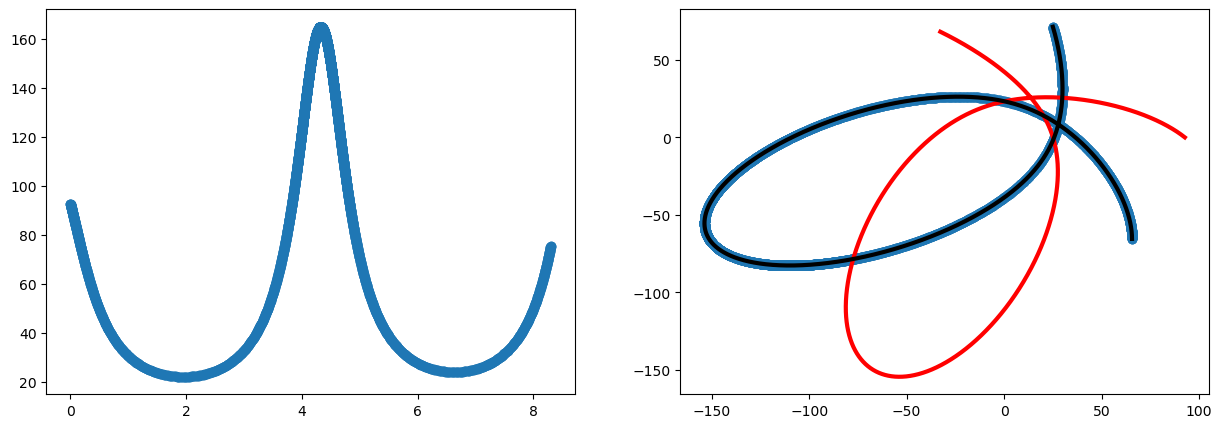

In [134]:
theta1 = np.arctan2(y_trail[0], x_trail[0])
unwrap_theta1 = np.unwrap(theta1) - first_theta[0]
theta_norm1 = (unwrap_theta1 + first_theta[0] + np.pi) % (2 * np.pi) - np.pi
r1 = np.sqrt(x_trail[0]**2 + y_trail[0]**2)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(unwrap_theta1, r1, label='0')
plt.subplot(1,2,2)
plt.scatter(x_trail[0], y_trail[0], label='0')
plt.plot(r1*np.cos(unwrap_theta1), r1*np.sin(unwrap_theta1), 'r', linewidth=3)
plt.plot(r1*np.cos(theta_norm1), r1*np.sin(theta_norm1), 'k', linewidth=3)


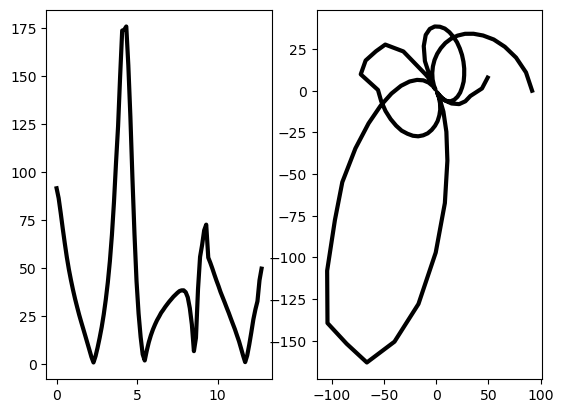

In [103]:
# Define bin edges

def average_column(x,y):
    bins = np.linspace(np.min(x), np.max(x), 101)

    # Bin the x array
    binned_x = np.digitize(x, bins)

    # Create a DataFrame for easy calculation
    df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

    # Group by the bin and calculate mean
    average_y_per_bin = df.groupby('bin')['y'].mean()

    return average_y_per_bin.to_numpy()

r_mean = average_column(theta_all, r_all)
theta_mean = np.linspace(np.min(theta_all), np.max(theta_all), len(r_mean))


plt.subplot(1,2,1)
plt.plot(theta_mean, r_mean, 'k', linewidth=3)
plt.subplot(1,2,2)
plt.plot(r_mean*np.cos(theta_mean), r_mean*np.sin(theta_mean), 'k', linewidth=3)

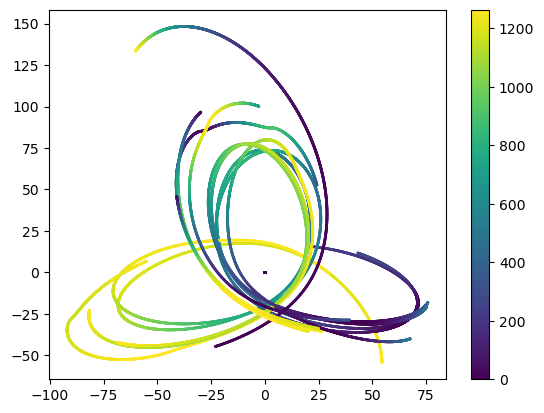

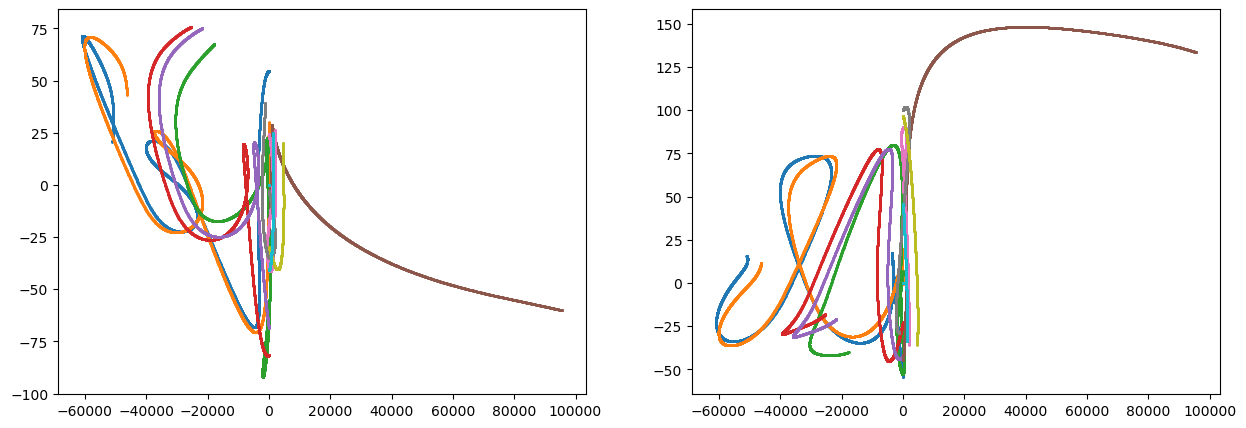

In [146]:
N = all_pos_N.shape[2]
t = all_pos_N.shape[1]
num_orbits = 10

for i in range(num_orbits):
    plt.scatter(all_pos_N[0, :, i * N//num_orbits], all_pos_N[1, :, i * N//num_orbits], c=all_xhi_N[0, :, i * N//num_orbits], s=1)
plt.colorbar()

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
for i in range(num_orbits):
    plt.scatter(all_xhi_N[0, :, i * N//num_orbits], all_pos_N[0, :, i * N//num_orbits], s=1)
plt.subplot(1,2,2)
for i in range(num_orbits):
    plt.scatter(all_xhi_N[0, :, i * N//num_orbits], all_pos_N[1, :, i * N//num_orbits], s=1)


In [148]:
x_all = np.zeros((num_orbits, t))
y_all = np.zeros((num_orbits, t))
xhi_all = np.zeros((num_orbits, t))
for i in range(num_orbits):
    x_all[i, :] = all_pos_N[0, :, i * N//num_orbits + 1]
    y_all[i, :] = all_pos_N[1, :, i * N//num_orbits + 1]
    xhi_all[i, :] = all_xhi_N[0, :, i * N//num_orbits + 1]


In [135]:
# Define bin edges
import pandas as pd

def average_column(x,y):
    bins = np.linspace(np.min(x), np.max(x), 101)

    # Bin the x array
    binned_x = np.digitize(x, bins)

    # Create a DataFrame for easy calculation
    df = pd.DataFrame({'x': x, 'y': y, 'bin': binned_x})

    # Group by the bin and calculate mean
    average_y_per_bin = df.groupby('bin')['y'].mean()

    return average_y_per_bin.to_numpy()

x_mean = average_column(xhi_all.flatten(), x_all.flatten())
y_mean = average_column(xhi_all.flatten(), y_all.flatten())

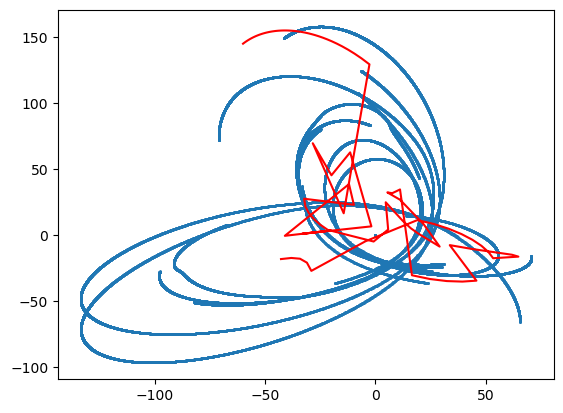

In [149]:
plt.scatter(x_all, y_all, s=1)
plt.plot(x_mean, y_mean, c='r')